In [1]:
import warnings
import time
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from datetime import datetime, timedelta
from getpass import getpass
import praw
import prawcore


try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

In [2]:
# Securely input credentials (enter your credentials when prompted)
client_id = getpass("Enter your Reddit Client ID: ")
client_secret = getpass("Enter your Reddit Client Secret (or press Enter for None): ")
if client_secret.strip() == "":
    client_secret = None  # Use None for installed apps

user_agent = "Stock Analysis 1.0 by /u/Stoic_Gaze"

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

In [23]:
def clean_text(text):
    """
    Clean text by removing user mentions, emojis, and common stopwords
    """
    if not isinstance(text, str):  # Check if text is a string
        return ""
    
    # Remove user mentions (e.g. u/username)
    text = re.sub(r'/?u/\w+', '', text)
    
    # Remove emojis - simple approach to remove most common emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    return text

def check_stock_mentions(text, target_stocks):
    """
    Check if text contains mentions of target stocks
    Returns: (has_mention, mentioned_tickers)
    """
    if not isinstance(text, str):  # Check if text is a string
        return 0, []
    
    # Define patterns for stock mentions
    # Match both $TICKER and just TICKER
    mentioned_tickers = []
    
    for ticker in target_stocks:
        # Remove $ if present for comparison
        clean_ticker = ticker.replace('$', '')
        
        # Check for ticker with or without $ prefix
        pattern = r'(\$' + clean_ticker + r'\b|\b' + clean_ticker + r'\b)'
        if re.search(pattern, text, re.IGNORECASE):
            mentioned_tickers.append(clean_ticker)
    
    has_mention = 1 if mentioned_tickers else 0
    return has_mention, mentioned_tickers

def remove_stopwords(text):
    """
    Remove common stopwords from text
    """
    if not isinstance(text, str):  # Check if text is a string
        return ""
    
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [ ]:
def redditScrape(reddit, subredditName, start_date, end_date, target_stocks=['TSLA', 'GME', 'AAPL', 'NVDA'], post_limit=1000):
    """
    Scrape Reddit posts with stock-specific enhancements
    
    Parameters:
    - reddit: Reddit API instance
    - subredditName: Subreddit to scrape
    - start_date: Datetime object for starting date
    - end_date: Datetime object for ending date
    - target_stocks: List of stock tickers to specifically track
    - post_limit: Maximum number of posts to retrieve
    
    Returns:
    - DataFrame with Reddit posts and stock-specific data
    """
    subreddit = reddit.subreddit(subredditName)
    posts = []
    
    # Normalize target_stocks to ensure consistent processing
    target_stocks = [ticker.replace('$', '').upper() for ticker in target_stocks]
    
    try:
        for post in subreddit.new(limit=post_limit):
            post_date = datetime.fromtimestamp(post.created_utc)
            
            if start_date <= post_date <= end_date:
                # Clean title and selftext for processing
                clean_title = clean_text(post.title)
                clean_selftext = clean_text(post.selftext)
                
                # Combined text for checking stock mentions
                combined_text = f"{clean_title} {clean_selftext}"
                
                # Check for stock mentions
                has_mention, mentioned_tickers = check_stock_mentions(combined_text, target_stocks)
                
                # Process text to remove stopwords
                processed_title = remove_stopwords(clean_title)
                processed_selftext = remove_stopwords(clean_selftext)
                
                posts.append({
                    'subreddit': subredditName,
                    'title': post.title,
                    'clean_title': processed_title,
                    'id': post.id,
                    'author': str(post.author),
                    'created_utc': post_date,
                    'score': post.score,
                    'upvote_ratio': post.upvote_ratio,
                    'num_comments': post.num_comments,
                    'url': post.url,
                    'selftext': post.selftext,
                    'clean_selftext': processed_selftext,
                    'has_target_stock': has_mention,
                    'mentioned_tickers': ','.join(mentioned_tickers) if mentioned_tickers else ''
                })
                
    except prawcore.exceptions.ResponseException as e:
        print(f"Reddit API returned an error: {e}. Waiting 60 seconds before retrying...")
        time.sleep(60)
        return redditScrape(reddit, subredditName, start_date, end_date, target_stocks, post_limit)
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(posts) if posts else pd.DataFrame()
    
    return pd.DataFrame(posts)


In [ ]:
# Define date range for scraping
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # Last 365 days

# Target stocks to track \
target_stocks = ['TSLA', '$GME', 'AAPL', '$NVDA']

# Subreddits to scrape
subreddits = ['wallstreetbets', 'stocks', 'investing']

all_data = pd.DataFrame()

for subreddit in subreddits:
    print(f"Scraping r/{subreddit}...")
    df = redditScrape(reddit, subreddit, start_date, end_date, target_stocks)
    
    if not df.empty:
        df['subreddit'] = subreddit
        all_data = pd.concat([all_data, df], ignore_index=True)
        
    # Rate Limiting for API
    time.sleep(2)


Scraping r/wallstreetbets...
Scraping r/stocks...
Scraping r/investing...


In [39]:
# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"reddit_stock_data_{timestamp}.csv"
all_data.to_csv(filename, index=False)

print(f"Scraping complete, Data saved to {filename}")

# Print summary statistics
print(f"\nSCRAPE SUMMARY:")
print(f"Total posts scraped: {len(all_data)}")
stock_mentions = all_data[all_data['has_target_stock'] == 1]
print(f"Posts with target stock mentions: {len(stock_mentions)}")

# Count by ticker (posts may mention multiple tickers)
ticker_counts = {}
for tickers in stock_mentions['mentioned_tickers'].dropna():
    if tickers:
        for ticker in tickers.split(','):
            ticker_counts[ticker] = ticker_counts.get(ticker, 0) + 1

print("\nMentions by ticker:")
for ticker, count in ticker_counts.items():
    print(f"- {ticker}: {count}")


Scraping complete, Data saved to reddit_stock_data_20250318_141712.csv

SCRAPE SUMMARY:
Total posts scraped: 2674
Posts with target stock mentions: 188

Mentions by ticker:
- TSLA: 83
- NVDA: 95
- AAPL: 32
- GME: 6


In [40]:
# Preview the data
display(all_data.head())

# Basic statistics
print("\nBasic Statistics:")
print(f"Most upvoted post: {all_data['score'].max()} upvotes")
print(f"Average upvote ratio: {all_data['upvote_ratio'].mean():.2f}")
print(f"Average number of comments: {all_data['num_comments'].mean():.1f}")

# Distribution of posts by subreddit
subreddit_counts = all_data['subreddit'].value_counts()
display(subreddit_counts)

,title,clean_title,id,author,created_utc,score,upvote_ratio,num_comments,url,selftext,clean_selftext,has_target_stock,mentioned_tickers,subreddit
0,TSLA puts gains. Time to go buy a Tesla.,TSLA puts gains. Time go buy Tesla.,1jebn8s,brokenb3ar,2025-03-18 14:12:35,0,0.33,1,https://i.redd.it/iuy8iwpiohpe1.jpeg,,,1,TSLA,wallstreetbets
1,College student (sophomore) looses everything ...,College student (sophomore) looses everything ...,1jeb7d8,ViraliaTube,2025-03-18 13:54:52,62,0.83,108,https://www.reddit.com/gallery/1jeb7d8,"I started trading options in October, one trad...","started trading options October, one trade wee...",0,,wallstreetbets
2,Always Diversify,Always Diversify,1jeb3uq,XB0XRecordThat,2025-03-18 13:50:59,20,1.00,1,https://i.redd.it/7qjnhyblkhpe1.jpeg,,,0,,wallstreetbets
3,NVDA GTC YOLO,NVDA GTC YOLO,1je9lr3,WingWorried6176,2025-03-18 12:50:27,15,0.89,15,https://www.reddit.com/gallery/1je9lr3,MAXIMUM FEAR surrounding the GTC. Hoping Jense...,MAXIMUM FEAR surrounding GTC. Hoping Jensen bl...,1,NVDA,wallstreetbets
4,Anyone else or just me?? $HIMS,Anyone else me?? $HIMS,1je9gyu,Control_the_Guh,2025-03-18 12:44:58,5,0.73,12,https://i.redd.it/h2uiwjvv8hpe1.jpeg,,,0,,wallstreetbets



Basic Statistics:
Most upvoted post: 104106 upvotes
Average upvote ratio: 0.74
Average number of comments: 349.0


subreddit
investing         963
stocks            878
wallstreetbets    833
Name: count, dtype: int64


Engagement Comparison:
Stock-related posts average score: 738.5
Non-stock posts average score: 469.1
Stock-related posts average comments: 124.0
Non-stock posts average comments: 366.0


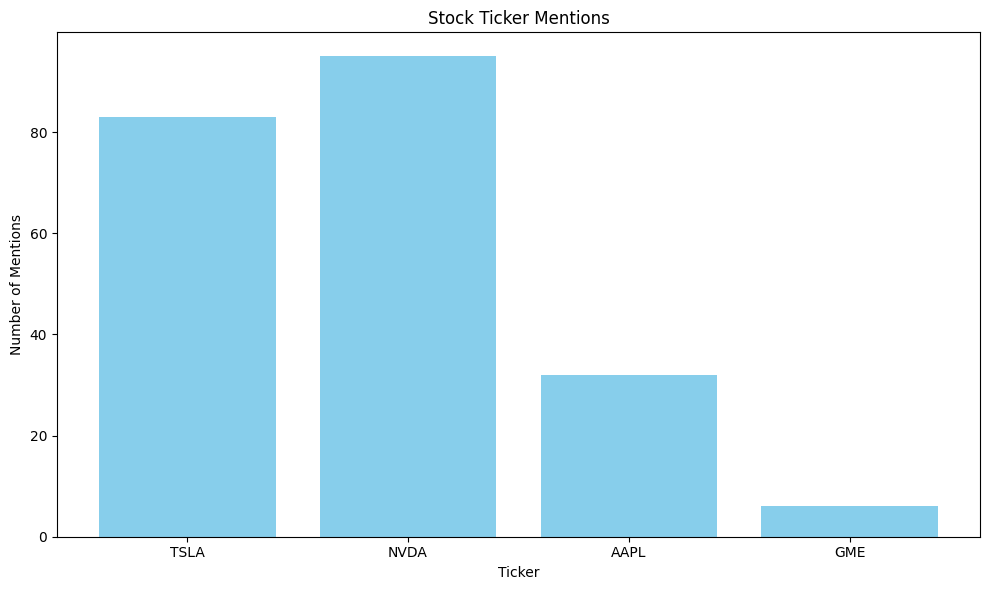

In [41]:
# Filter posts with stock mentions
stock_posts = all_data[all_data['has_target_stock'] == 1].copy()

# Calculate average engagement for stock-related posts
stock_avg_score = stock_posts['score'].mean()
stock_avg_comments = stock_posts['num_comments'].mean()

# Calculate average engagement for non-stock posts
non_stock_posts = all_data[all_data['has_target_stock'] == 0]
non_stock_avg_score = non_stock_posts['score'].mean()
non_stock_avg_comments = non_stock_posts['num_comments'].mean()

print("\nEngagement Comparison:")
print(f"Stock-related posts average score: {stock_avg_score:.1f}")
print(f"Non-stock posts average score: {non_stock_avg_score:.1f}")
print(f"Stock-related posts average comments: {stock_avg_comments:.1f}")
print(f"Non-stock posts average comments: {non_stock_avg_comments:.1f}")

import matplotlib.pyplot as plt
    
# Create a bar chart of ticker mentions
plt.figure(figsize=(10,6))
tickers = list(ticker_counts.keys())
counts = list(ticker_counts.values())
plt.bar(tickers, counts, color='skyblue')
plt.title('Stock Ticker Mentions')
plt.xlabel('Ticker')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()